In [9]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import sys
import kuka_utils as u
from scipy.stats import pearsonr
from scipy.stats import linregress

In [10]:
#code from Stefan Hendricks for floenavi https://gitlab.awi.de/floenavi-crs/icedrift
from datetime import datetime
import sys
# Allow to find icedrift 
# NOTE: this only works if `floenavi` (this module) and `icedrift` are cloned to the same directory
# sys.path.append('Users⁩/rosie⁩/Documents⁩/code⁩/python⁩/')
sys.path.append('../icedrift/')

from icedrift import GeoReferenceStation, IceCoordinateSystem, GeoPositionData

def dt64todt(dt64):
    """
    Convert datetime 64 objects to datetime.datetime
    :param dt64:
    :return:
    """
    timestamps = (dt64 - np.datetime64('1970-01-01T00:00:00Z')) / np.timedelta64(1, 's')
    dt = np.ndarray(timestamps.shape, dtype=object)
    for i, ts in enumerate(timestamps):
        dt[i] = datetime.utcfromtimestamp(ts)
    return dt


In [3]:
#set file path for SMP data
file_path = '/Users/rosie/Documents/mosaic/mosaic_data/DW_SMP/'

#get the areas from kuka_utils
areas = u.areas()

#get all the kuka x and y locations
xy = pickle.load( open('/Volumes/bigLacie/processed_stare_new_nrcs/' + '/x_y_p/x_y_all_' + 'Ku' + '.p', 'rb')) 
#this is just a file of all the x and y coordinates from all x_y_p files

In [4]:
#Use data from  https://doi.pangaea.de/10.1594/PANGAEA.927460 tab separated value file 
#selecting the lines of SMP processed bulk densities during November 7th 2019 - January 31st 2020


data = pd.read_csv(
    file_path + 'SnowMicroPen_MOSAiC.tab.tsv',
    names = ['ref', 'dt', 'lat', 'lon', 'hs', 'swe', 'comment'], skiprows = 298,
    nrows = 1272-298+1, sep = '\t')

#get the lats and lons
alat = data.lat.to_numpy()
alon = data.lon.to_numpy()

#remove profiles where location not known
keep = np.where((alat == alat)  & (alon == alon)) 
lon = alon[keep]
lat = alat[keep]

#get other info from data
dtf = data.dt.to_numpy()[keep]
hs = data.hs.to_numpy()[keep]
swe = data.swe.to_numpy()[keep]
comment = data.comment.to_numpy()[keep]

#get the datetime info from dtf
year = [int(t[0:4]) for t in dtf]
month = [int(t[5:7]) for t in dtf]
day = [int(t[8:10]) for t in dtf]
hour = [int(t[11:13]) for t in dtf]
minute = [int(t[14:16]) for t in dtf]
second = [int(t[17:19]) for t in dtf]

#convert into datetime
dt = [datetime(year[i], month[i], day[i], hour[i], minute[i], second[i]) for i in range(len(dtf))]

#convert to seconds since Jan 1st 1970 
dts = np.array([(dti - datetime(1970,1,1)).total_seconds() for dti in dt])

#determine which profiles were on which leg
leg1 = np.where(np.array(dts) < 1576281600)[0]
leg2 = np.where((np.array(dts) > 1576281600) & (np.array(dts) < 1582588800))[0]
# print('leg1', len(leg1), 'leg2', len(leg2))

#make arrays to contain x and y floe-referenced coodinates
x_array = np.full(len(lon), np.nan)
y_array = np.full(len(lon), np.nan)

#put leg 1 data through floenavi
for i in leg1:
    if i/10 == round(i/10):
        print('i', i)
    try:
        refstat = GeoReferenceStation.from_csv(r"../floenavi/data/master-solution/mosaic-leg1-20191016-20191213-floenavi-refstat-v1p0.csv")
        icecs = IceCoordinateSystem(refstat) 
        spos = GeoPositionData(np.array(dt)[[i]], lon[[i]], lat[[i]])
        sicepos = icecs.get_xy_coordinates(spos)
        x_array[i] = sicepos.xc
        y_array[i] = sicepos.yc
    except:
        pass

#put leg 2 data through floenavi
for i in leg2:
    if i/10 == round(i/10):
        print('i', i)
    try:
        refstat = GeoReferenceStation.from_csv(r"../floenavi/data/master-solution/mosaic-leg2-20191214-20200224-floenavi-refstat-v1p0.csv")
        icecs = IceCoordinateSystem(refstat) 
        spos = GeoPositionData(np.array(dt)[[i]], lon[[i]], lat[[i]])
        sicepos = icecs.get_xy_coordinates(spos)
        x_array[i] = sicepos.xc
        y_array[i] = sicepos.yc
    except:
        pass



i 0
i 10
i 20
i 30
i 40
i 50
i 60
i 70
i 80
i 90
i 100
i 110
i 120
i 130
i 140
i 150
i 160
i 170
i 180
i 190
i 200
i 210
i 220
i 230
i 240
i 250
i 260
i 270
i 280
i 290
i 300
i 310
i 320
i 330
i 340
i 350
i 360
i 370
i 380
i 390
i 400
i 410
i 420
i 430
i 440
i 450
i 460
i 470
i 480
i 490
i 500
i 510
i 520
i 530
i 540
i 550
i 560
i 570
i 580
i 590
i 600
i 610
i 620
i 630
i 640
i 650
i 660
i 670
i 680
i 690
i 700
i 710
i 720
i 730
i 740
i 750
i 760
i 770
i 780
i 790
i 800
i 810
i 820
i 830
i 840


(-1000.0, 1500.0)

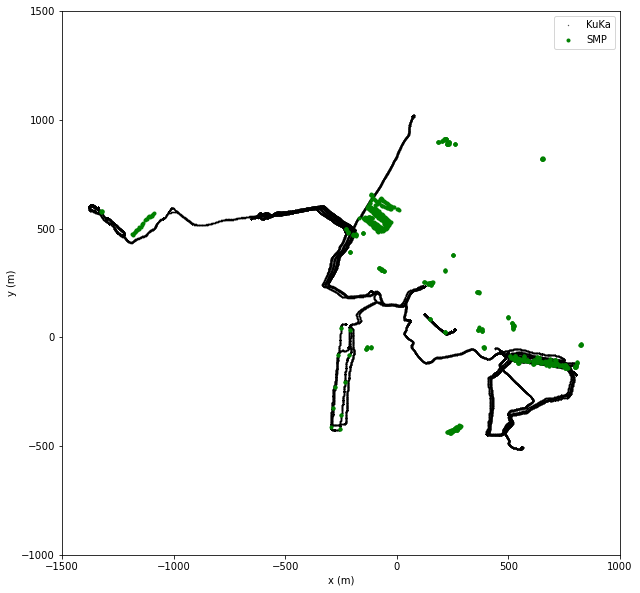

In [5]:
#plot the locations of the KuKa and SMP data

f = plt.figure(figsize = (10, 10))
plt.plot(xy['x'], xy['y'], 'k.', label = 'KuKa', markersize = .6)
plt.plot(x_array, y_array, 'g.', label = 'SMP')

plt.legend()
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.xlim(-1500,1000)
plt.ylim(-1000,1500)

In [6]:
#save the data via pickle
dw_tsv = {'dts': dts,
          'dt': dt,
         'lon': lon,
         'lat': lat,
         'x_array': x_array,
         'y_array': y_array,
         'hs': hs,
         'swe': swe,
         'comment':comment
         }

pickle.dump(dw_tsv, open(file_path+'/dw_tsv.p', 'wb'))

SMP density
slope, intercept, r_l, p_l, se
4.410409405920197e-06 258.3836611967684 0.3574577589135928 7.193457859080854e-27 3.9687559532142545e-07
r,p 0.35745775891359277 7.193457859082355e-27
min and max dens: 176.25 415.3846153846154
line [258.3836612  290.50521979]
densification in kg/m3 per month: 11.431781180145153
---
c_prime
slope, intercept, r_l, p_l, se
-2.2019229657469222e-09 0.8190510333218564 -0.3614349546137251 1.7830807095062173e-27 1.9564069727291288e-10
r,p -0.3614349546137251 1.7830807095065172e-27
min and max c_prime: 0.7475957451111801 0.86552516660553
line [0.81905103 0.80301416]
0.86552516660553 0.7475957451111801


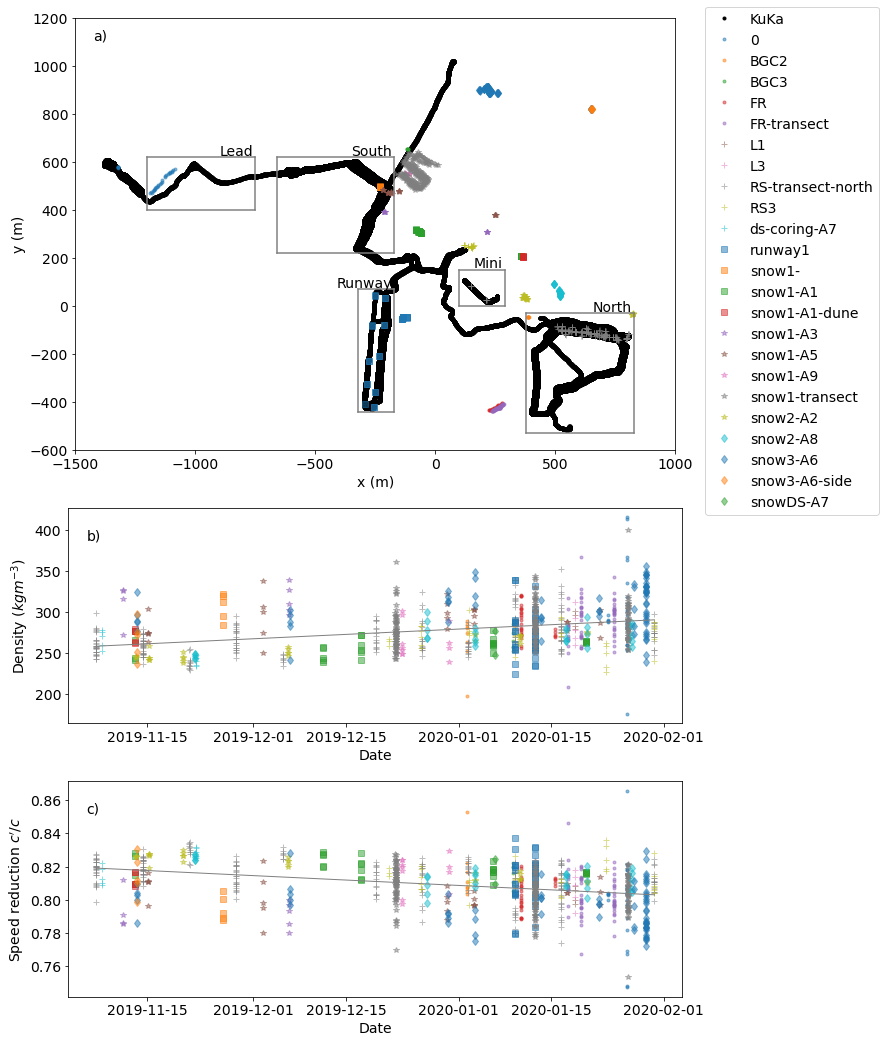

In [14]:
#calculate bulk densities and make figure (as shown in paper) 

#calculate bulk densities
dens = swe/hs

# pickle.load(open(file_path + '/dw_tsv.p', 'rb'))

#set the plot up
plt.rcParams.update({'font.size': 14})
f, ax = plt.subplots(3, 1, figsize = (11, 18), gridspec_kw={'height_ratios': [2, 1, 1]})

#PLOT 0: map of KuKa and SMP locations

#add all kuka x and y locations
ax[0].plot(xy['x'], xy['y'], 'k.', label = 'KuKa')

#find all the areas as designated in the 'location' column of the SMP data
area_l = np.unique(comment)
sym = ['.', '+', 's', '*', 'd']

#plot out the SMP data locations
for a in area_l:
    aindex = np.where(area_l == a)[0]
    s = sym[int(aindex/area_l.shape[0]*5)]
    here = np.where(dw_tsv['comment'] == a)[0]
    ax[0].plot(x_array[here], y_array[here], s,
                     label = a, alpha = .5)
    
#add on rectangles and labels for transects etc. 
for key in areas:
    ax[0].plot(areas[key]['x'][0:2], [areas[key]['y'][0],areas[key]['y'][0]], color = 'grey')
    ax[0].plot(areas[key]['x'][0:2], [areas[key]['y'][1],areas[key]['y'][1]] , color = 'grey')
    ax[0].plot([areas[key]['x'][0],areas[key]['x'][0]], areas[key]['y'][0:2] , color = 'grey')
    ax[0].plot([areas[key]['x'][1],areas[key]['x'][1]], areas[key]['y'][0:2] , color = 'grey')
    ax[0].text(areas[key]['x'][1]-10, areas[key]['y'][1]+10, key, ha = 'right')
    
#plot labels etc. 
ax[0].set_xlabel('x (m)')
ax[0].set_ylabel('y (m)')
ax[0].set_aspect('equal')
ax[0].set_xlim(-1500,  1000)
ax[0].set_ylim(-600, 1200)
ax[0].text(.03, .95, 'a)', transform = ax[0].transAxes)
  
    
#PLOT 1: SMP density through time and by location

for a in area_l:
    aindex = np.where(area_l == a)[0]
    s = sym[int(aindex/area_l.shape[0]*5)]
    here = np.where(np.array(dw_tsv['comment']) == a)[0]
    ax[1].plot(np.array(dt)[here], 
        dens[here], 
        s,
        label = a, 
        alpha = .5)


#calculate slope, intercept, r and p values by converting time to seconds since first measurement
slope, intercept, r_l, p_l, se = linregress([(x - dt[0]).total_seconds() for x in dt], dens)
r, p = pearsonr([(x - dt[0]).total_seconds() for x in dt], dens)

print('SMP density')
print('slope, intercept, r_l, p_l, se')
print(slope, intercept, r_l, p_l, se)
print('r,p', r,p)
print('min and max dens:', min(dens), max(dens))
line_x = (dt[0], dt[-1])
line_y = np.array([(x - dt[0]).total_seconds() for x in line_x])*slope + intercept
print('line', line_y)
# print('densification in kg/m3 per month:', (line_y[-1] - line_y[0])/(line_x[-1] - line_x[0]))
print('densification in kg/m3 per month:', slope*30*24*60*60)
print('---')
ax[1].plot(line_x, line_y, 'grey', linewidth = 1, label = 'linear fit')

#plot labels etc
lgd = ax[0].legend(loc = (1.05, -.15))
ax[1].set_xlabel('Date')
ax[1].set_ylabel(r'Density ($kg m^{-3}$)')
ax[1].text(.03, .85, 'b)', transform = ax[1].transAxes)


#PLOT 2: reduced velocity through time and by location
c_prime = 1/np.sqrt(1+1.9*dens/1000)
for a in area_l:
    aindex = np.where(area_l == a)[0]
    s = sym[int(aindex/area_l.shape[0]*5)]
    here = np.where(np.array(dw_tsv['comment']) == a)[0]
    ax[2].plot(np.array(dt)[here], 
        c_prime[here], 
        s,
        label = a, 
        alpha = .5)

ax[2].set_xlabel('Date')
ax[2].set_ylabel(r'Speed reduction $c^{\prime}/c$')
ax[2].text(.03, .85, 'c)', transform = ax[2].transAxes)



#calculate slope, intercept, r and p values
slope, intercept, r_l, p_l, se = linregress([(x - dt[0]).total_seconds() for x in dt], c_prime)
r, p = pearsonr([(x - dt[0]).total_seconds() for x in dt], c_prime)

print('c_prime')
print('slope, intercept, r_l, p_l, se')
print(slope, intercept, r_l, p_l, se)
print('r,p', r,p)
print('min and max c_prime:', min(c_prime), max(c_prime))
line_x = (dt[0], dt[-1])
line_y = np.array([(x - dt[0]).total_seconds() for x in line_x])*slope + intercept
print('line', line_y)
ax[2].plot(line_x, line_y, 'grey', linewidth = 1, label = 'linear fit')


#save plot
plt.savefig('/Users/rosie/Documents/papers/mac_rosie_mosaic/SMP_velocity.jpg', 
            bbox_extra_artists=(lgd,), 
            bbox_inches='tight', dpi = 600)

print(max(c_prime), min(c_prime))